# Ü3B - Abdullah Barhoum (5041774), Katharina Müller (5284090)

# Assignment 3: Histogram of Oriented Gradients (HOG)
## Read paper
Have a look at the section "Resources" in the KVV and read the original HOG work of Dalal and Triggs from 2005 and the good summary by Tomasi (I would read this first). Now you shouldn't have any problems with the implementation of the algorithm! 

## MIT-DB for people
Download the complete image data set here: http://pascal.inrialpes.fr/data/human/ 


In [1]:
%matplotlib inline
from skimage import io, color, transform
from skimage.util import crop
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, rotate
import cv2
from os.path import join, normpath
import re
from math import floor

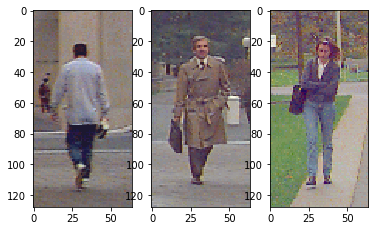

In [2]:
pers1 = io.imread('images/per00002.ppm')
pers2 = io.imread('images/per00007.ppm')
pers3 = io.imread('images/per00014.ppm')

fig = plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(pers1)
ax2.imshow(pers2)
ax3.imshow(pers3)


## Gradients and directions
First, implement the extraction of the gradient via convolution with the Sobel kernels. Translate the two result matrices into an image containing the gradient direction (one angle per pixel). Display this image for each of the three input images above. Like it fancy? Add transparency inversely proportional to the gradient magnitude (weak gradients are transparent). 

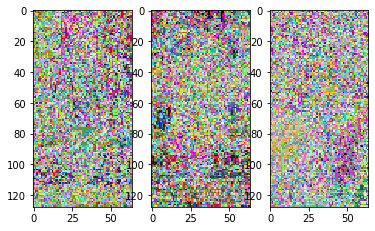

In [3]:
def getGradientConv(image, for_render=False):
    # the paper states that this filter is better than the Sobel filter
    # Dalal and Triggs, 2005, chapter 6.2
    Sx = np.array([[[-1, 0, 1]]])
    Gx, Gy = convolve(image, Sx), convolve(image, Sx.T)
    G  = np.sqrt(np.square(Gx) + np.square(Gy)).astype(np.float32)
    if for_render: # scale to 0 - 1
        G = G + np.amin(G)
        G = G / np.amax(G)
    return G, Gx, Gy

# test
fig = plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(getGradientConv(pers1, True)[0])
ax2.imshow(getGradientConv(pers2, True)[0])
ax3.imshow(getGradientConv(pers3, True)[0])

## Gradient orientation histograms (GOHs)
Now implement a function that generates GOHs on image cells. Pass a gradient direction image (as described above) to the function. The image cells should be 8 x 8 pixels in size. Please do not forget the voting with "bi-linear interpolation" (important!). Compute the GOH for the input image "star.png" with and without interpolation! Now rotate the image by -5° and compute both variants of the GOH again! What are the Euclidean differences of the histograms (original vs rotated) with and without interpolation?


In [4]:
star = io.imread('images/star.png')

def getKey(y, x):
    return str(y) + ", " + str(x)

def GOH(image, interpolate=True):
    G, Gx, Gy = getGradientConv(image)
    hists = {}
    H, W, C = image.shape
    B = 9
    Wi = 180 / B
    for y in range(0, H, 8):
        for x in range(0, W, 8):
            gx = Gx[y:y + 8, x:x + 8]
            gy = Gy[y:y + 8, x:x + 8]
            theta = 180 / np.pi * (np.arctan2(gy, gx) % np.pi)
            # TODO: is this reshaping correct?
            # we might be losing information about pixel colors
            # because we are flatenning the whole array
            g = G[y:y + 8, x:x + 8].reshape(-1)
            theta = theta.reshape(-1)
            bins = np.zeros(B, np.float32)
            if interpolate:
                for angle, gradient in zip(theta, g):
                    bin_index = int(angle // Wi)
                    bin_center = bin_index * Wi + Wi/2
                    diff_from_center = angle - bin_center
                    percent_this_bin = abs(diff_from_center) / Wi
                    bins[bin_index] += percent_this_bin * gradient
                    
                    percent_next_bin = 1 - percent_this_bin
                    next_bin_offset = 1 if diff_from_center >= 0 else -1
                    next_bin_index = (bin_index + next_bin_offset + B) % B
                    bins[ next_bin_index ] += percent_next_bin * gradient
                        
                        
                    """
                    # this is too ugly and too hard to understand
                    j = int(floor(angle / Wi - 0.5) + B) % B
                    cj1 = Wi * (j + 1.5)
                    vj = gradient * (cj1 - angle) / Wi
                    cj = Wi * (j + 0.5)
                    vj1 = gradient * (angle - cj) / Wi
                    bins[j] += vj
                    bins[ (j + 1) % B] += vj1
                    """
            else:
                for angle, gradient in zip(theta, g):
                    bins[int(angle // Wi)] += gradient
            hists[getKey(y, x)] = bins
    return hists



normal_interpolated = GOH(star)
normal = GOH(star, False)

def crop_center(img,cropy,cropx):
    y,x, _ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

im2 = crop_center(rotate(star, -5, mode='nearest'), star.shape[0], star.shape[1])
rotated_interpolated = GOH(im2)
rotated = GOH(im2, False)

In [5]:
# compare Eucledian distances
def compare(hists1, hists2):
    v1 = np.concatenate(list(hists1.values()))
    v2 = np.concatenate(list(hists2.values()))
    return euc_dist(v1, v2)

def euc_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

print('Distance between normal and rotated', 
    compare(normal, rotated)
 )

print('Distance between interpolated normal and interpolated rotated', 
    compare(normal_interpolated, rotated_interpolated)
 )

Distance between normal and rotated 5153.942
Distance between interpolated normal and interpolated rotated 5137.8623


## Block and ROI normalization and creation of the HOG descriptor
* Given a fixed size ROI (128 x 64 pixels), create a descriptor as shown in the lecture (including normalization of the blocks and the total ROI). Please reuse the precalculated cell histograms for the blocks! 
* Calculate the descriptor for the three images above and for the unknown images "unknown1.png" and "unknown2.png". 
* Now compare the unknowns with the three person instances and calculate the Euclidean distance of the descriptors. Which picture has a smaller distance to the persons? (**RESULT**)

In [6]:
def block_norm(a):
    return a / np.sqrt(np.linalg.norm(a) + 1e-6)


def norm_descriptor(image):
    hists = GOH(image)
    H, W, C = image.shape
    blocks = []
    for y in range(0, H, 8):
        for x in range(0, W, 8):
            keys = [
                getKey(y    ,     x),
                getKey(y + 8,     x),
                getKey(y    , x + 8),
                getKey(y + 8, x + 8)
            ]
            if not all(key in hists for key in keys):
                continue

            b = np.concatenate(list(map(hists.get, keys)))
            blocks.append(block_norm(b))

    h = np.concatenate(blocks)
    h = block_norm(h)
    h[h > 0.2] = 0.2
    h = block_norm(h)
    return h

In [8]:
unknown1 = io.imread('images/unknown1.png', as_gray=False, pilmode="RGB")
unknown2 = io.imread('images/unknown2.png', as_gray=False, pilmode="RGB")

h_per1 = norm_descriptor(pers1)
h_per2 = norm_descriptor(pers2)
h_per3 = norm_descriptor(pers3)

h_unknown1 = norm_descriptor(unknown1)
h_unknown2 = norm_descriptor(unknown2)

dist1 = euc_dist(h_unknown1, h_per1) + euc_dist(h_unknown1, h_per2) + euc_dist(h_unknown1, h_per3)
dist2 = euc_dist(h_unknown2, h_per1) + euc_dist(h_unknown2, h_per2) + euc_dist(h_unknown2, h_per3)

print('Distance from unknown 1 to people', dist1)
print('Distance from unknown 2 to people', dist2)
print('Distance of unknown', 1 if dist1 < dist2 else 2, 'is smaller')

Distance from unknown 1 to people 8.630018
Distance from unknown 2 to people 8.633408
Distance of unknown 1 is smaller
